Joint Representation
=================

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AllenWLynch/MIRA/blob/main/docs/source/notebooks/tutorial_joint_representation.ipynb)

In this tutorial, we will use pre-trained topic models to create a joint representation of the the SHARE-seq dataset which embeds cells in a low-dimensional space based on both accessibility and expression modailities. The joint embedding space can be used to calculate a joint-KNN graph that better captures differentiation trajectories and cellular heterogeneity. The joint-KNN graph can be used for UMAP visualization, clustering, and pseudotime trajectory inference.

To make your own joint representation, make sure you follow the previous tutorial for training topic models, and train a topic model both expression and accesibility modalities

First, we need to import some packages:

In [1]:
!pip install mira-multiome scanpy==1.8.2 numpy==1.20.1 #uncomment for Colab notebook

In [1]:
import mira
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font',size=12)
import numpy as np
import logging
import seaborn as sns
mira.logging.getLogger().setLevel(logging.INFO)
import warnings
warnings.simplefilter("ignore")

umap_kwargs = dict(
    add_outline=True, outline_width=(0.1,0), outline_color=('grey', 'white'),
    legend_fontweight=350, frameon = False, legend_fontsize=12
)
print(mira.__version__)
mira.utils.pretty_sderr()

2.0.0a1


In [2]:
mira.datasets.ShareseqTopicModels()

INFO:mira.datasets.datasets:Dataset already on disk.
INFO:mira.datasets.datasets:Dataset contents:
	* mira-datasets/shareseq_topic_models
		* atac_model.pth
		* rna_model.pth


and download some data. The following tutorials will demonstrate MIRA's features using the SHARE-seq Skin study from [Ma et al. 2020](https://www.cell.com/cell/pdf/S0092-8674(20)31253-8.pdf).

In [3]:
mira.datasets.ShareseqBaseData()

INFO:mira.datasets.datasets:Dataset already on disk.
INFO:mira.datasets.datasets:Dataset contents:
	* mira-datasets/shareseq_base_data
		* atac_data.h5ad
		* rna_data.h5ad


Next we load data:

In [4]:
rna_data = anndata.read_h5ad('mira-datasets/shareseq_base_data/rna_data.h5ad')
atac_data = anndata.read_h5ad('mira-datasets/shareseq_base_data/atac_data.h5ad')

And our topic models:

In [5]:
rna_model = mira.topics.load_model('mira-datasets/shareseq_topic_models/rna_model.pth')
atac_model = mira.topics.load_model('mira-datasets/shareseq_topic_models/atac_model.pth')

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [6]:
atac_model.encoder.calc_readdepth = False

## Predicting topics

Using our models, we can predict topic compositions for our cells. The topics are a distribution over expression of genes, so cell-topic compositions represent how much different modules of gene expression are active in a cell.

The `predict` method takes the requisite AnnData objects as input and saves the topic compositions for cells and features.

In [7]:
atac_model.predict(atac_data)
rna_model.predict(rna_data)

Predicting latent vars:   0%|          | 0/112 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/112 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Next, we wish to use those cell-topic compositions as features to find cells which are in similar states. Compositions are in the simplex space, which can distort inter-cell distances. Therefor, we convert the simplical topic compositions to *Real* space using the *Isometric log ratio* (ILR) transformation.

The parameter `box_cox` controls the box-cox power transformation applied to the simplical data. Passing zero or "log" gives the standard ILR transformation. Passing a float less than one gives a box-cox generalization of the ILR. Larger values generally produce more complex structures in the latent space. *No value works perfectly for all datasets, so please see the section below for more details.*

In [8]:
rna_model.get_umap_features(rna_data, box_cox=0.25)
atac_model.get_umap_features(atac_data, box_cox=0.25)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


Let's visualize how the topics describe cell populations and variance in the dataset. We'll start by creating separate visualizations for expression and accessibility. First, we need use the embedding space to create a K-nearsest neighbors graph using `sc.pp.neighbors`. To make sure the correct embeddings are used, make sure to specify `use_rep = 'X_joint_umap_features'`. Also, specify `metric = 'manhattan'` to leverage the orthonormality of ILR-transformed space to find cells in similar states.

One application of the joint-KNN graph is to calculate a 2-D UMAP view of the data. When calculating UMAPs, setting `min_dist = 0.1` highlights lineage structures and reduces the "fuzziness" of the UMAP view.

We do this for both modalities below:

In [9]:
sc.pp.neighbors(rna_data, use_rep = 'X_umap_features', metric = 'manhattan', n_neighbors = 21)
sc.tl.umap(rna_data, min_dist = 0.1)
rna_data.obsm['X_umap'] = rna_data.obsm['X_umap']*np.array([-1,-1]) # flip for consistency
sc.pp.neighbors(atac_data, use_rep = 'X_umap_features', metric = 'manhattan', n_neighbors = 21)
sc.tl.umap(atac_data, min_dist = 0.1)
atac_data.obsm['X_umap'] = atac_data.obsm['X_umap']*np.array([1,-1]) # flip for consistency

In [10]:
atac_data.obs = atac_data.obs.join(rna_data.obs.true_cell, how = 'left')
atac_data.obs.true_cell = atac_data.obs.true_cell.astype(str)

... storing 'true_cell' as categorical


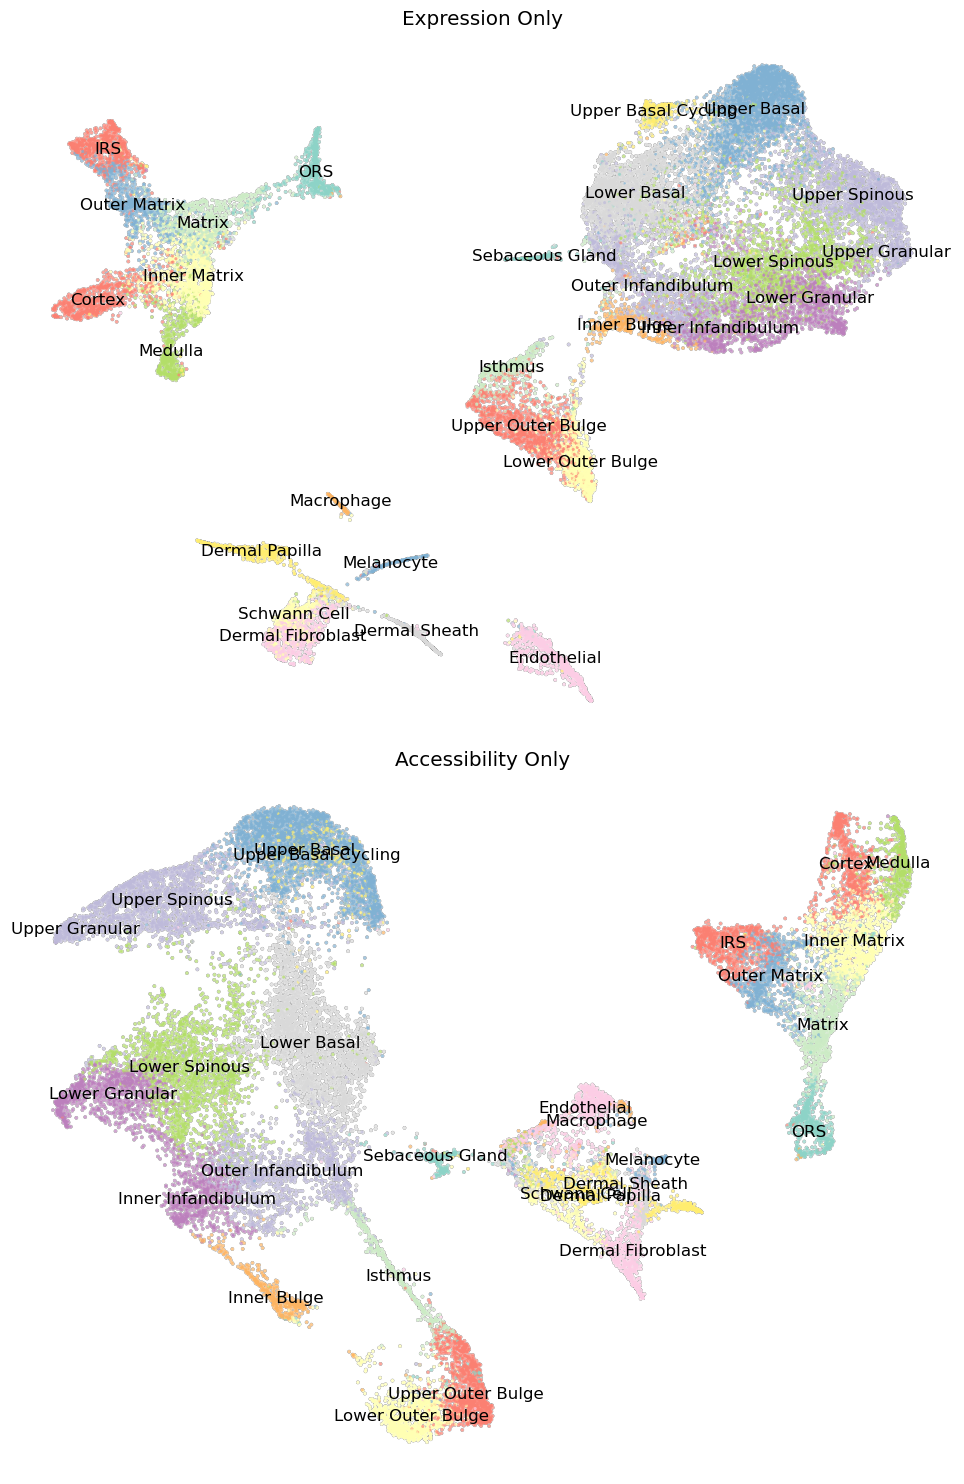

In [11]:
palette = dict(zip(
    atac_data.obs.true_cell.unique(), [sns.color_palette('Set3')[(i+1)%12] for i in range(30)]
))

fig, ax = plt.subplots(2,1,figsize=(10,15))
sc.pl.umap(rna_data, color = 'true_cell', legend_loc = 'on data', ax = ax[0], size = 20,
          **umap_kwargs, title = 'Expression Only', show = False, palette=palette)

sc.pl.umap(atac_data, color = 'true_cell', legend_loc = 'on data', ax = ax[1], size = 20,
          **umap_kwargs, title = 'Accessibility Only', show = False, na_color = 'lightgrey',
          palette=palette)
plt.tight_layout()
plt.show()

## Joining modalities

Now, let's combine the modailities. We can construct the joint embedding space using [mira.utils.make_joint_representation](../utils/mira.utils.make_joint_representation.html#mira.utils.make_joint_representation). This function takes the two modalities' AnnDatas as input, then finds common cells, joins the separate transformed topic spaces to make the joint embedding for each cell, and returns those AnnDatas.

In [12]:
rna_data, atac_data = mira.utils.make_joint_representation(rna_data, atac_data)

INFO:mira.adata_interface.utils:28429 out of 28429 cells shared between datasets (100%).
INFO:mira.adata_interface.utils:Key added to obsm: X_joint_umap_features


Finally, we can use the joint embedding space to create the joint-KNN graph using:

In [13]:
sc.pp.neighbors(rna_data, use_rep = 'X_joint_umap_features', metric = 'manhattan',
               n_neighbors = 20)

And visualize the joint-KNN graph using UMAP. The UMAP view below, as analyzed thoroughly in the [MIRA paper](https://www.biorxiv.org/content/10.1101/2021.12.06.471401v1.full.pdf) reveals interesting aspects of skin differentiation biology.

In [14]:
sc.tl.umap(rna_data, min_dist = 0.1)

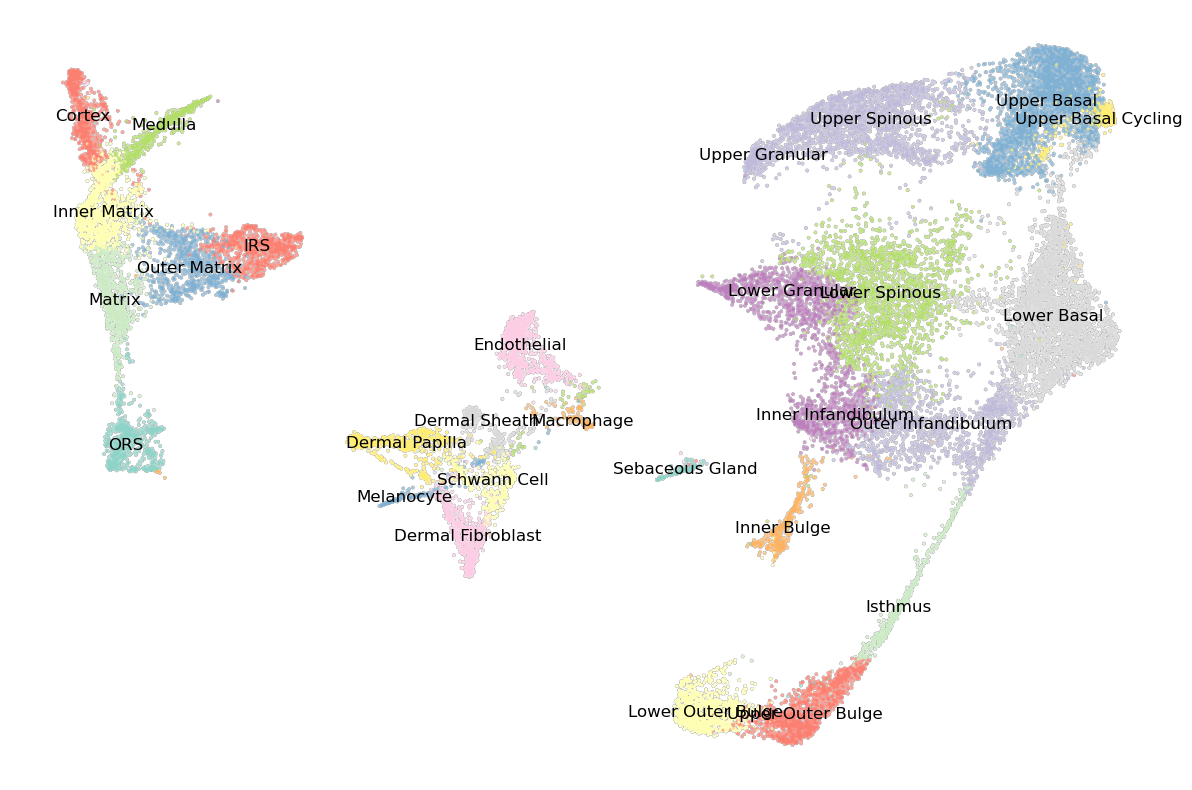

In [15]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
sc.pl.umap(rna_data, color = 'true_cell', legend_loc = 'on data', ax = ax, size = 20,
          **umap_kwargs, title = '')

After joining the AnnDatas, it is useful to transfer some metadata from the ATAC dataframe to the RNA dataframe so that we have one main object for plotting and running other functions: 

In [16]:
rna_data.obs = rna_data.obs.join(
    atac_data.obs.add_prefix('ATAC_') # add a prefix so we know which AnnData the column came from
)

atac_data.obsm['X_umap'] = rna_data.obsm['X_umap']

## Analyzing joint topic compositions

One question we can answer with topics is finding to what degree changes in one mode's topics correspond or correlate with topics in the other mode. For this we can use the **mutual information** between RNA and ATAC topic compositions. Mutual information measures how much knowing one variable informs you about the distribution of another variable, or in this case, does knowing about the composition of one mode tell you about the other?

We can ask this question on a cell-by-cell basis with the [mira.tl.get_cell_pointwise_mutual_information](../tools/mira.tl.get_cell_pointwise_mutual_information.html#mira.tl.get_cell_pointwise_mutual_information) function, which calculates the pointwise mutual information between topics for in that cell:

In [17]:
mira.tl.get_cell_pointwise_mutual_information(rna_data, atac_data)

INFO:mira.adata_interface.core:Added cols to obs: pointwise_mutual_information


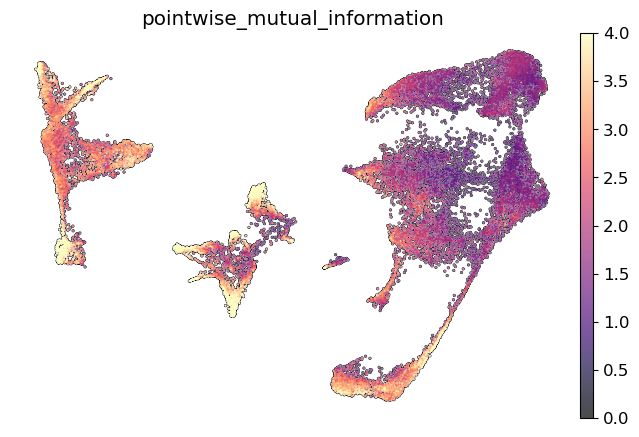

In [18]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
sc.pl.umap(rna_data, color = 'pointwise_mutual_information', ax = ax, vmin = 0,
          color_map='magma', frameon=False, add_outline=True, vmax = 4, size = 7)

Usually, more stable cell states, such as terminal cell states, will have greater concordance between topic compositions.

To summarize mutual information across all cells, use [mira.tl.summarize_mutual_information](../tools/mira.tl.summarize_mutual_information.html#mira.tl.summarize_mutual_information). Typically, this will give a value between 0 -low concordance- and 0.5 -high concordance.

In [19]:
mira.tl.summarize_mutual_information(rna_data, atac_data)

0.35590148

Finally, one can see which topics correlate across modes. Use:

In [20]:
cross_correlation = mira.tl.get_topic_cross_correlation(rna_data, atac_data)

Which returns a dataframe of cross-correlations between modes. Seaborn's `cluster_map` function is useful for plotting this type of data:

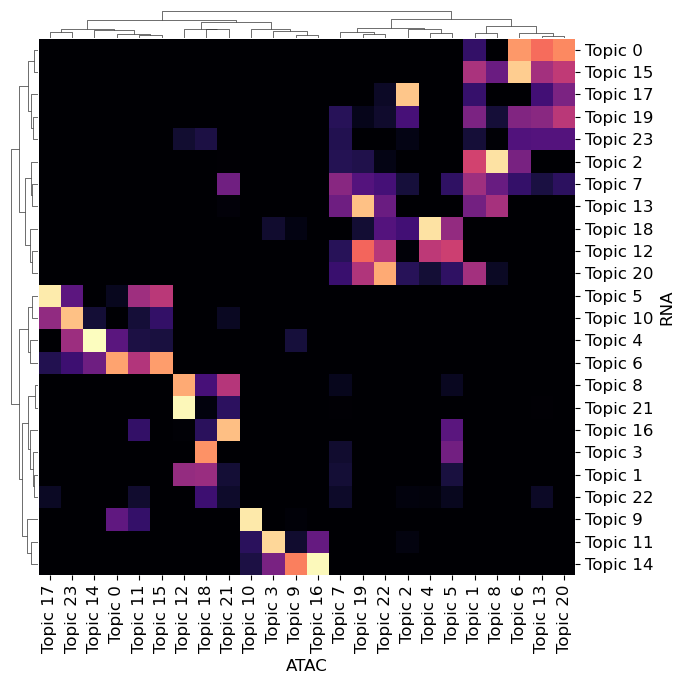

In [21]:
sns.clustermap(cross_correlation, vmin = 0, 
               cmap = 'magma', method='ward', 
               dendrogram_ratio=0.05, cbar_pos=None, figsize=(7,7))

Interestingly, most topics have a clear partner in the other modality with which they correlate.

## The box-cox parameter

Now, let's isolate the hair follicle system and show the effects of tuning the `box_cox` parameter on the UMAP view. 

In [22]:
hair_follicle = rna_data[
    rna_data.obs.true_cell.isin(
        ['ORS','Matrix','IRS','Outer Matrix','Inner Matrix','Medulla','Cortex'])
    ]

hair_follicle_atac = atac_data[hair_follicle.obs_names]
hair_follicle_atac.obsm['X_umap'] = hair_follicle.obsm['X_umap']

Turn off logging so we aren't swamped with messages:

In [23]:
mira.adata_interface.core.logger.setLevel(logging.WARN)
mira.adata_interface.topic_model.logger.setLevel(logging.WARN)
mira.adata_interface.utils.logger.setLevel(logging.WARN)

Then iterate over some possible values for the `box_cox` parameter, colored by cell type for comparisons between plots.

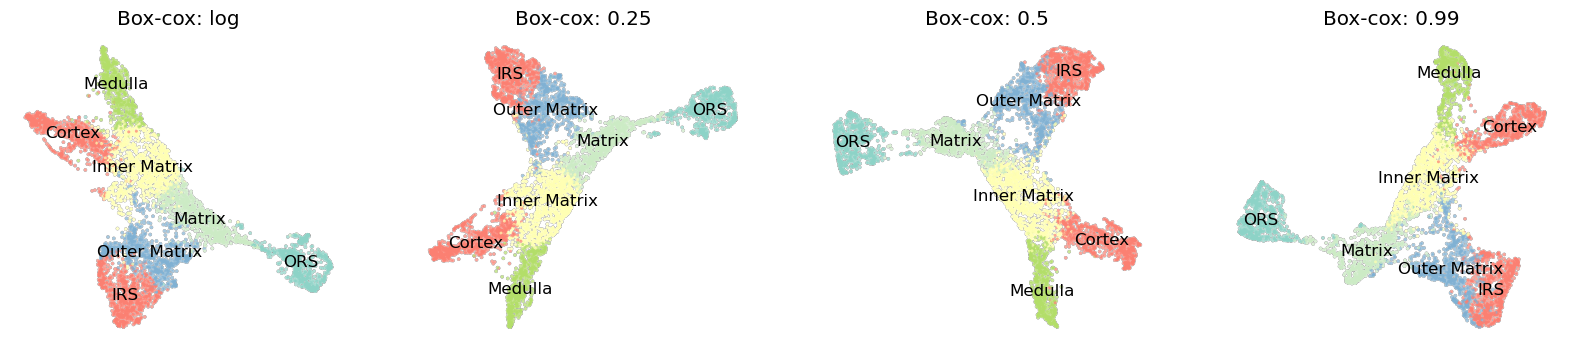

In [24]:
def boxcox_test(ax, box_cox, rna, atac):
    
    atac_model.get_umap_features(atac, box_cox=box_cox)
    rna_model.get_umap_features(rna, box_cox=box_cox)

    rna, atac = mira.utils.make_joint_representation(rna, atac)

    sc.pp.neighbors(rna, use_rep = 'X_joint_umap_features', metric = 'manhattan', n_neighbors = 20)
    sc.tl.umap(rna, min_dist = 0.1)
    sc.pl.umap(rna, ax = ax, show = False, title = 'Box-cox: ' + str(box_cox),
              color = 'true_cell', color_map = 'Set3', legend_loc='on data',
              add_outline=True, outline_width=(0.1,0), outline_color=('grey', 'white'),
              legend_fontweight=150, frameon = False, legend_fontsize=12)
    
fig, ax = plt.subplots(1,4, figsize=(20,4))
for ax_i, box_cox in zip(ax, ['log',0.25,0.5,0.99]):
    boxcox_test(ax_i, box_cox, hair_follicle, hair_follicle_atac)

plt.show()

We see that as the `box_cox` parameter increases, some finer details in the manifold emerge, such as multiple paths between the *Matrix* and *IRS* cells. For the hair follicle, "log" and 0.99 hide meaningful structure in the data, so it is clear that the optimal `box_cox` transformation for this dataset is somewhere in the realm of 0.25 to 0.5. Notably, **the underlying topic compositions have not changed**, just our definition of the joint-KNN graph and our subsequent view of the it in UMAP space.

Try multiple values for `box_cox` to find a view that sufficiently demonstrates the connectivity structure of the data.

Overall, in constructing the joint representation and ensuing visual representation of the data (atleast with UMAP), there are several hyperparameters to consider:

| Parameter | Source | What it does | Good value |
| -- | -- | -- | -- |
| box_cox | MIRA | Controls box-cox power transformation of topic compositions. A value of zero/"log" performs ILR trasformation. Larger values give a box-cox generalization of ILR and generally find more complex structure in the data. | "log", 0.25, 0.5, 0.75 |
| n_neighbors | MIRA | Number of neighbors in joint-KNN graph. Greater values increase "clumpiness" of joint KNN and remove finer structures and neighborhoods | 15 |
| min_dist | UMAP | How close together can cells of similar state be placed in 2-D space. Lower values decrease "fuzziness" of UMAP. | 0.1 |
| negative_sample_rate | UMAP | Repulsive force of UMAP algorithm. Decreasing this parameter makes UMAP view more similar to force-directed layouts, where attractive forces are prioritized. | 1 - 5 |

With the joint representation made, we can investigate regulatory axes captued by the topics. Please view the next tutorial to see MIRA's topic analyis facilities, including motif calling and regulator enrichment.